In [1]:
import os
import gc
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import random
import albumentations as albu

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import segmentation_models_pytorch as smp
        
%matplotlib inline

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [4]:
TRAIN_DATA_DIR = '../input/bdd-100-test/binary_lane_bdd'
MODEL_SAVE_DIR = "../working/"

TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 8 # kept low considering the compute available

torch.cuda.empty_cache()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda', index=0)

# Helper Functions

In [6]:
def display_pil_images(
    images, 
    masks=None,
    labels=None,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=9):

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
        if masks is not None:
            masks= masks[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    
    if masks is not None:
        for i, (image, mask) in enumerate(zip(images,masks)):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
            plt.imshow(mask, cmap='coolwarm', alpha=0.5)
            
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size); 
            
    else:
        for i, image in enumerate(images):
            plt.subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image)
        
            if labels is not None:
                plt.title(labels[i], fontsize=label_font_size);
    

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

# Image Directory

In [7]:
train_img_paths, train_mask_paths = [], []
for item1 in os.listdir(TRAIN_DATA_DIR+'/Images/'):
    train_img_paths.append(TRAIN_DATA_DIR+'/Images/'+item1)
for item2 in os.listdir(TRAIN_DATA_DIR+'/Labels/'):
    train_mask_paths.append(TRAIN_DATA_DIR+'/Labels/'+item2)

In [8]:
train_img_paths[:5]

['../input/bdd-100-test/binary_lane_bdd/Images/6476e7bc-27412c9b.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Images/a5a31acc-04315ff3.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Images/01759047-d88724fe.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Images/76b72431-ad59e77f.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Images/26354f19-e5870011.jpg']

In [9]:
train_mask_paths[:5]

['../input/bdd-100-test/binary_lane_bdd/Labels/6476e7bc-27412c9b.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/a5a31acc-04315ff3.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/01759047-d88724fe.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/76b72431-ad59e77f.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/26354f19-e5870011.jpg']

## Getting mask proportion per image to maintain a valid CV split.

In [10]:
mask_df = pd.DataFrame()
mask_df['file_names'] = train_mask_paths

In [11]:
from tqdm import tqdm_notebook

In [12]:
mask_df.head()

file_names
0  ../input/bdd-100-test/binary_lane_bdd/Labels/6...
1  ../input/bdd-100-test/binary_lane_bdd/Labels/a...
2  ../input/bdd-100-test/binary_lane_bdd/Labels/0...
3  ../input/bdd-100-test/binary_lane_bdd/Labels/7...
4  ../input/bdd-100-test/binary_lane_bdd/Labels/2...

In [13]:
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in tqdm_notebook(train_mask_paths):
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(1280*720*255)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
mask_df['mask_percentage'].describe()

count    501.000000
mean       0.055905
std        0.033480
min        0.001062
25%        0.029924
50%        0.053179
75%        0.077354
max        0.180167
Name: mask_percentage, dtype: float64

In [15]:
mask_df['below'] = 0
mask_df['below'][mask_df['mask_percentage']<0.01] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
mask_df['below'].sum()

31

In [17]:
mask_df['below'].sum()/mask_df.shape[0]

0.06187624750499002

In [18]:
train_img_paths = sorted(train_img_paths)
train_mask_paths = sorted(train_mask_paths)
        
print(train_img_paths[:5])
print(train_mask_paths[:5])

['../input/bdd-100-test/binary_lane_bdd/Images/0028cbbf-92f30408.jpg', '../input/bdd-100-test/binary_lane_bdd/Images/004071a4-049b7b85.jpg', '../input/bdd-100-test/binary_lane_bdd/Images/010526ea-7a0c620d.jpg', '../input/bdd-100-test/binary_lane_bdd/Images/015ccf71-56e8d5b8.jpg', '../input/bdd-100-test/binary_lane_bdd/Images/01759047-d88724fe.jpg']
['../input/bdd-100-test/binary_lane_bdd/Labels/0028cbbf-92f30408.jpg', '../input/bdd-100-test/binary_lane_bdd/Labels/004071a4-049b7b85.jpg', '../input/bdd-100-test/binary_lane_bdd/Labels/010526ea-7a0c620d.jpg', '../input/bdd-100-test/binary_lane_bdd/Labels/015ccf71-56e8d5b8.jpg', '../input/bdd-100-test/binary_lane_bdd/Labels/01759047-d88724fe.jpg']


# View images and masks

Showing 15 images of 200:


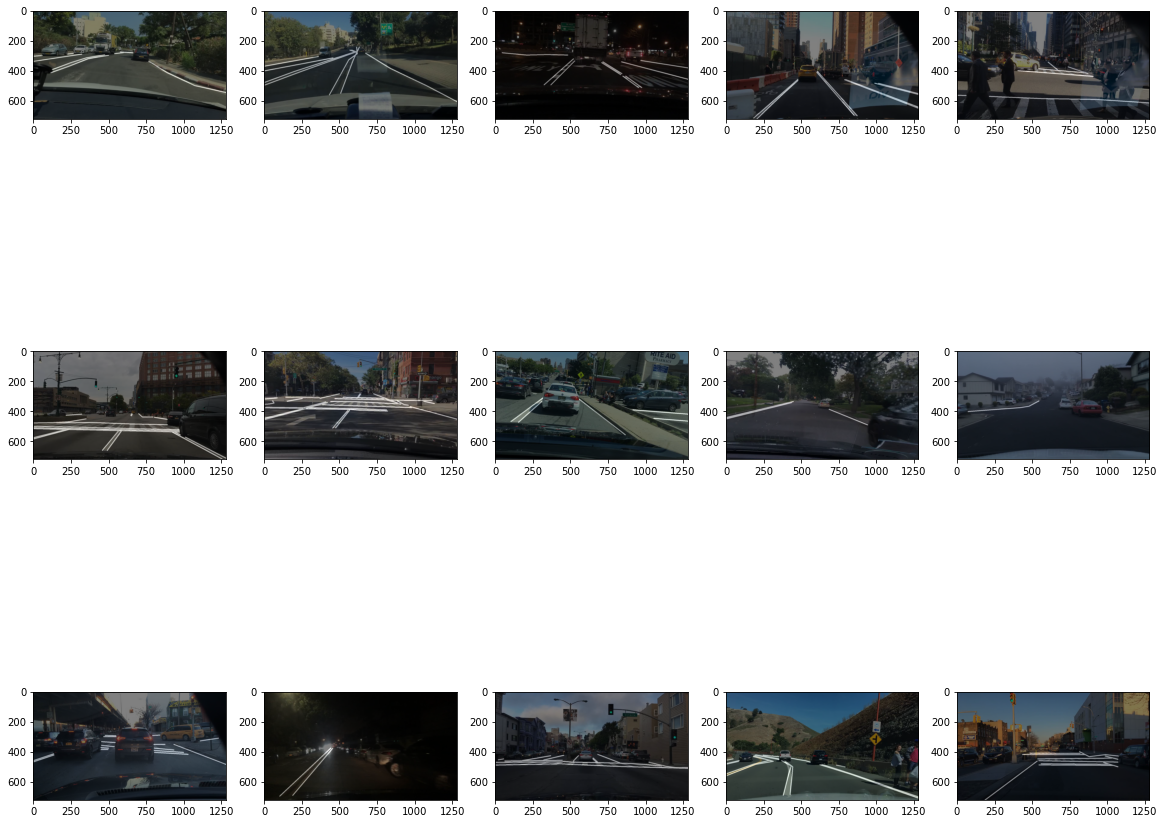

In [19]:
imgs = [Image.open(img_path) for img_path in train_img_paths]
masks = [Image.open(mask_path) for mask_path in train_mask_paths]
display_pil_images(imgs[300:500], masks[300:500])

### Looks like labels have been made by using shape detection algorithms, due to that few labels were wrongly interpreted which in turn would induce biases in the model.

# Dataset class

In [20]:
class SegDataset(D.Dataset):
    
    def __init__(
            self, 
            paths, 
            mode,
            augmentation=None,
            preprocessing=None,
    ):

        self.paths = paths
        self.mode = mode
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):       
        if self.mode in ['train', 'val']:
            image = cv.imread(self.paths[i][0])
            image = cv.resize(image, (512, 512)) #resizing the image resolution in the run-time. 
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            mask = cv.imread(self.paths[i][1], 0)
            mask = cv.resize(mask, (512, 512))
            mask = np.expand_dims(mask, axis=2)
        else:
            image = cv.imread(self.paths[i])
            image = cv.resize(image, (512, 512))
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.augmentation:
            if self.mode in ['train', 'val']:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.augmentation(image=image)
                image = sample['image']

        if self.preprocessing:
            if self.mode in ['train', 'val']:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                sample = self.preprocessing(image=image)
                image = sample['image']

        if self.mode in ['train', 'val']:
            return image, mask
        
        return image
        
    def __len__(self):
        return len(self.paths)

## Applying Standard Augmentations to increase the amount of data.

In [21]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),
        albu.ShiftScaleRotate(scale_limit=0.4, rotate_limit=0, shift_limit=0.3, p=0.33, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    _transform = [
        albu.Normalize(mean=(0.485, 0.456, 0.406), 
                       std=(0.229,0.224,0.225), 
                       max_pixel_value=255.0, always_apply=True, p=1.0),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [22]:
train_mask_paths[:5]

['../input/bdd-100-test/binary_lane_bdd/Labels/0028cbbf-92f30408.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/004071a4-049b7b85.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/010526ea-7a0c620d.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/015ccf71-56e8d5b8.jpg',
 '../input/bdd-100-test/binary_lane_bdd/Labels/01759047-d88724fe.jpg']

In [23]:
mask_df.sort_index(inplace=True, ascending=True)

In [24]:
mask_df.head()

mask_percentage  below
file_names                                                                
../input/bdd-100-test/binary_lane_bdd/Labels/00...         0.067866      0
../input/bdd-100-test/binary_lane_bdd/Labels/00...         0.031877      0
../input/bdd-100-test/binary_lane_bdd/Labels/01...         0.042211      0
../input/bdd-100-test/binary_lane_bdd/Labels/01...         0.033880      0
../input/bdd-100-test/binary_lane_bdd/Labels/01...         0.039487      0

In [25]:
train_paths, val_paths = train_test_split(list(zip(train_img_paths, train_mask_paths)),
                                        test_size=0.15,  
                                        random_state=SEED,
                                        shuffle=True, stratify=mask_df['below'])

print("Amount of train samples:", len(train_paths))
print("Amount of val samples:", len(val_paths))

Amount of train samples: 425
Amount of val samples: 76


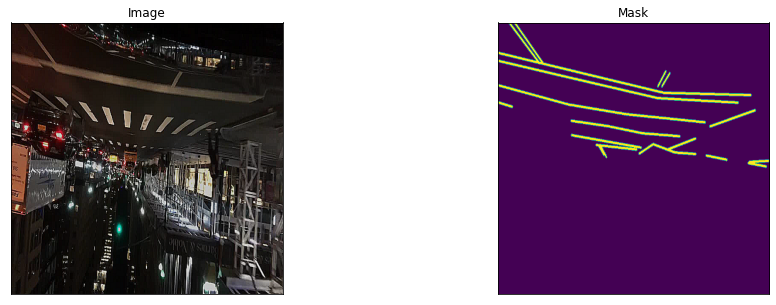

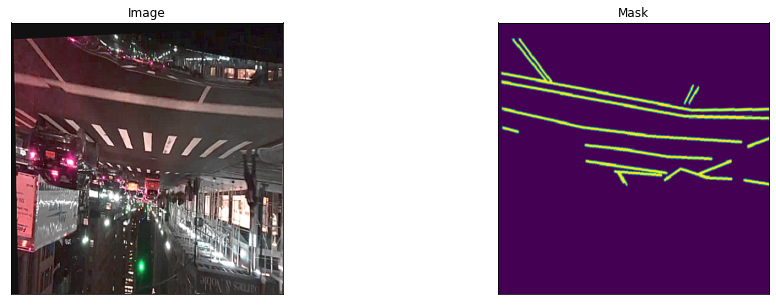

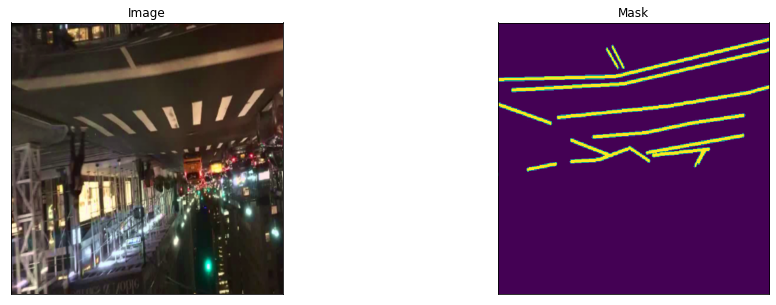

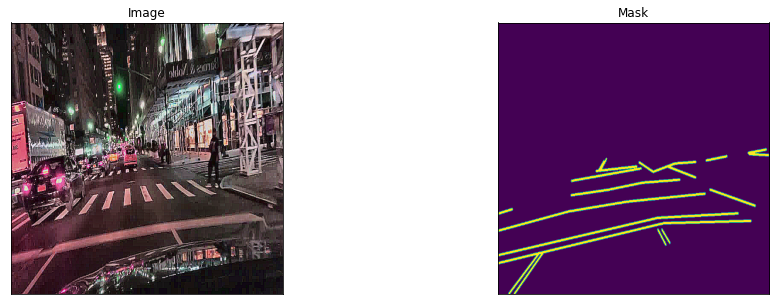

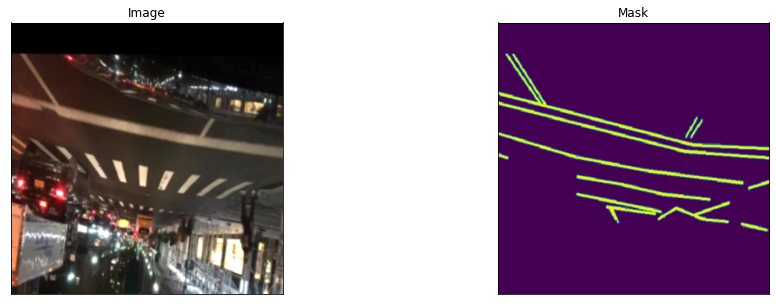

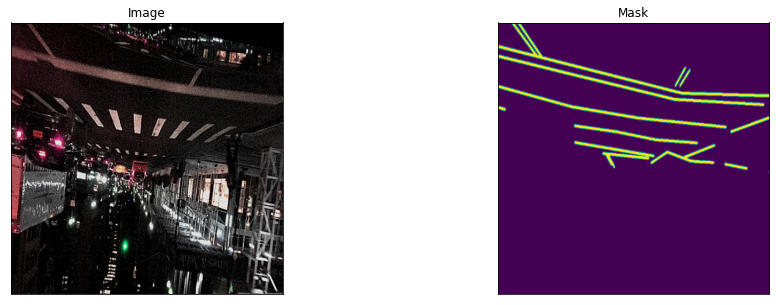

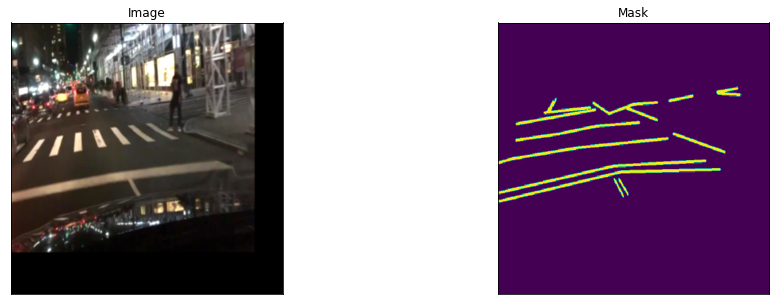

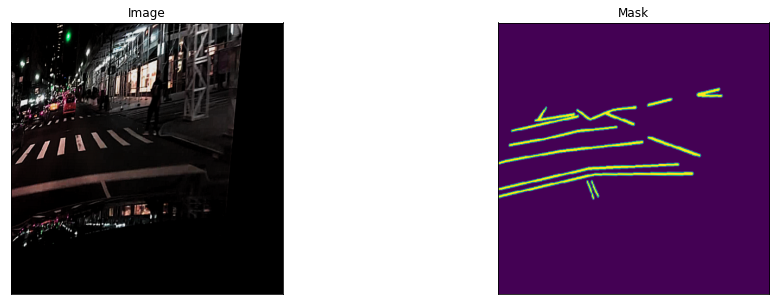

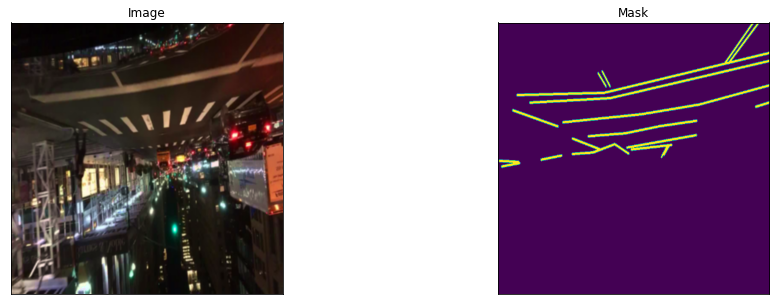

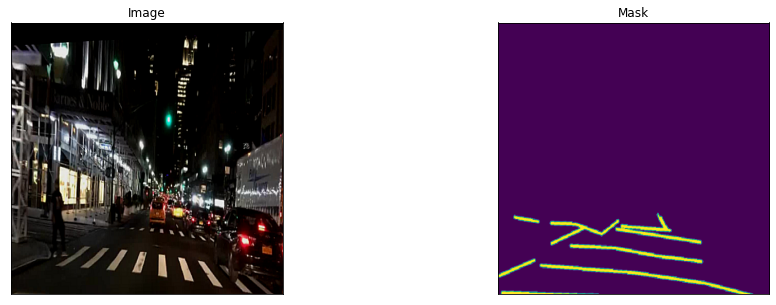

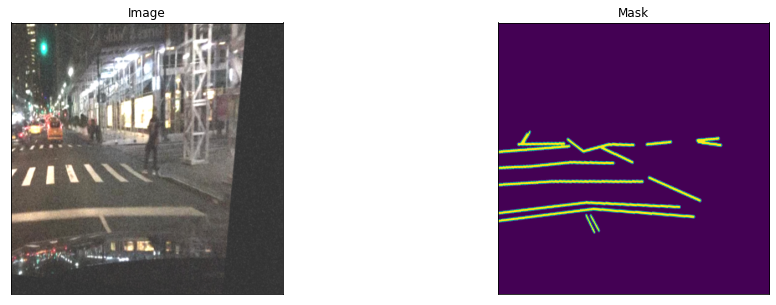

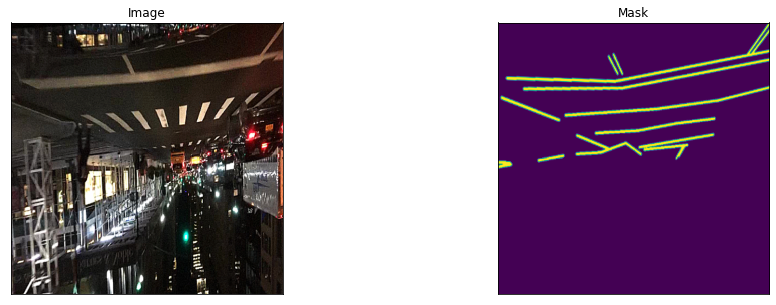

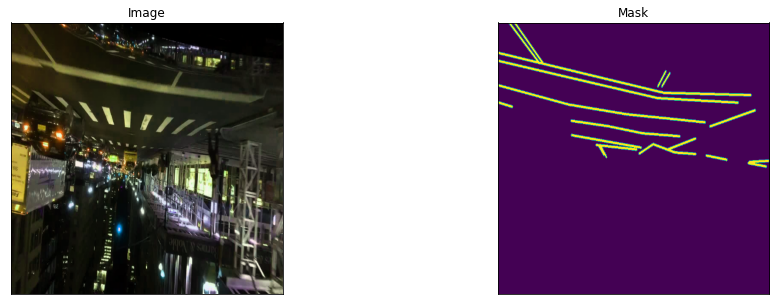

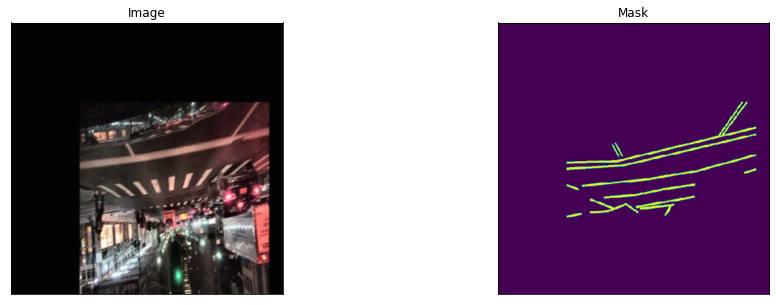

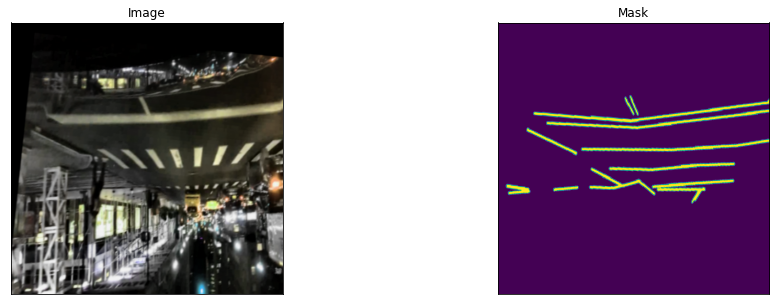

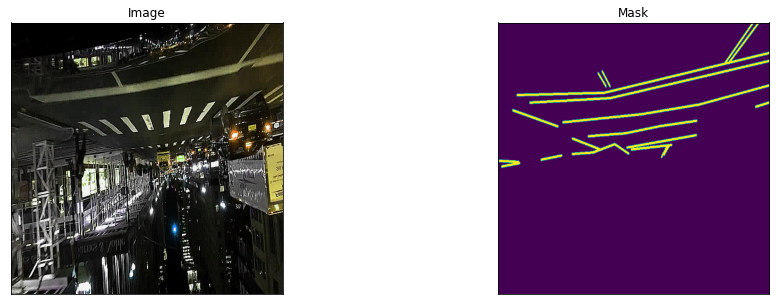

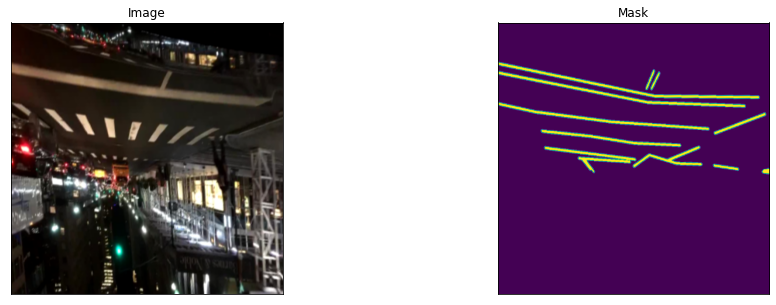

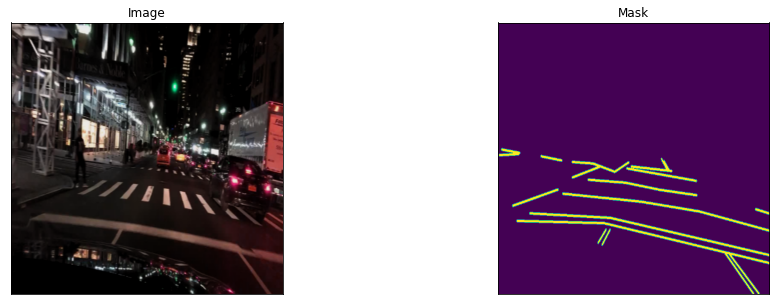

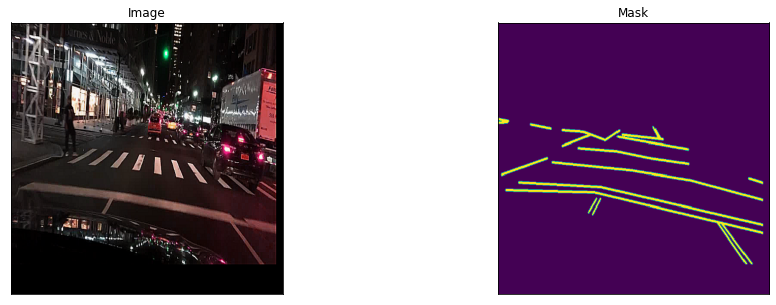

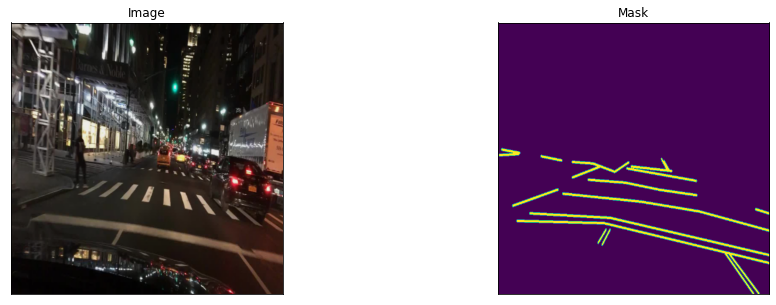

In [26]:
augmented_dataset = SegDataset(train_paths,
                                  'train',
                                  augmentation=get_training_augmentation(),
                                )

for i in range(20):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

# Model

In [27]:
## LaneNet's loss function

from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import torch
from torch.functional import F

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DiscriminativeLoss(_Loss):

    def __init__(self, delta_var=0.5, delta_dist=1.5, norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 usegpu=True, size_average=True):
        super(DiscriminativeLoss, self).__init__(reduction='mean')
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.usegpu = usegpu
        assert self.norm in [1, 2]

    def forward(self, input, target):
        # _assert_no_grad(target)
        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, embedding, seg_gt):
        batch_size = embedding.shape[0]
        embed_dim = embedding.shape[1]

        var_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        dist_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        reg_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)

        for b in range(batch_size):
            embedding_b = embedding[b]  # (embed_dim, H, W)
            seg_gt_b = seg_gt[b]

            labels = torch.unique(seg_gt_b)
            labels = labels[labels != 0]
            num_lanes = len(labels)
            if num_lanes == 0:
                _nonsense = embedding.sum()
                _zero = torch.zeros_like(_nonsense)
                var_loss = var_loss + _nonsense * _zero
                dist_loss = dist_loss + _nonsense * _zero
                reg_loss = reg_loss + _nonsense * _zero
                continue

            centroid_mean = []
            for lane_idx in labels:
                seg_mask_i = (seg_gt_b == lane_idx)
                if not seg_mask_i.any():
                    continue
                embedding_i = embedding_b[seg_mask_i]

                mean_i = torch.mean(embedding_i, dim=0)
                centroid_mean.append(mean_i)

                var_loss = var_loss + torch.mean(F.relu(
                    torch.norm(embedding_i - mean_i, dim=1) - self.delta_var) ** 2) / num_lanes
            centroid_mean = torch.stack(centroid_mean)  # (n_lane, embed_dim)

            if num_lanes > 1:
                centroid_mean1 = centroid_mean.reshape(-1, 1, embed_dim)
                centroid_mean2 = centroid_mean.reshape(1, -1, embed_dim)
                dist = torch.norm(centroid_mean1 - centroid_mean2, dim=2)  # shape (num_lanes, num_lanes)
                dist = dist + torch.eye(num_lanes, dtype=dist.dtype,
                                        device=dist.device) * self.delta_dist  # diagonal elements are 0, now mask above delta_d

                # divided by two for double calculated loss above, for implementation convenience
                dist_loss = dist_loss + torch.sum(F.relu(-dist + self.delta_dist) ** 2) / (
                        num_lanes * (num_lanes - 1)) / 2

            # reg_loss is not used in original paper
            # reg_loss = reg_loss + torch.mean(torch.norm(centroid_mean, dim=1))

        var_loss = var_loss / batch_size
        dist_loss = dist_loss / batch_size
        reg_loss = reg_loss / batch_size
        return var_loss, dist_loss, reg_loss


class HNetLoss(_Loss):
    """
    HNet Loss
    """

    def __init__(self, gt_pts, transformation_coefficient, name, usegpu=True):
        """
        :param gt_pts: [x, y, 1]
        :param transformation_coeffcient: [[a, b, c], [0, d, e], [0, f, 1]]
        :param name:
        :return: 
        """
        super(HNetLoss, self).__init__()

        self.gt_pts = gt_pts

        self.transformation_coefficient = transformation_coefficient
        self.name = name
        self.usegpu = usegpu

    def _hnet_loss(self):
        """
        :return:
        """
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)
        loss = torch.mean(torch.pow(self.gt_pts.t()[0, :] - x_transformation_back[0, :], 2))

        return loss

    def _hnet(self):
        """
        :return:
        """
        self.transformation_coefficient = torch.cat((self.transformation_coefficient, torch.tensor([1.0])),
                                                    dim=0)
        H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8])
        H_shape = 9
        H = torch.zeros(H_shape)
        H.scatter_(dim=0, index=H_indices, src=self.transformation_coefficient)
        H = H.view((3, 3))

        pts_projects = torch.matmul(H, self.gt_pts.t())

        Y = pts_projects[1, :]
        X = pts_projects[0, :]
        Y_One = torch.ones(Y.size())
        Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
                                      Y_stack.t()),
                         X.view(-1, 1))

        x_preds = torch.matmul(Y_stack, w)
        preds = torch.stack((x_preds.squeeze(), Y, Y_One), dim=1).t()
        return (H, preds)

    def _hnet_transformation(self):
        """
        """
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)

        return x_transformation_back

    def forward(self, input, target, n_clusters):
        return self._hnet_loss(input, target)

In [28]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None

model = smp.Unet(encoder_name=ENCODER, encoder_depth=5, decoder_channels=[256,126,64,32,16],
                 encoder_weights=ENCODER_WEIGHTS, activation=ACTIVATION)

loss = smp.utils.losses.BCEWithLogitsLoss()

metrics = [
    smp.utils.metrics.Accuracy(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


# DataLoaders.

In [29]:
train_dataset = SegDataset(train_paths, 
                              'train',
                              augmentation=get_training_augmentation(), 
                              preprocessing=get_preprocessing()
                            )

valid_dataset = SegDataset(val_paths,
                              'val',
                              augmentation=get_validation_augmentation(), 
                              preprocessing=get_preprocessing()
                            )

train_loader = D.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = D.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Train loop

In [30]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [31]:
NUM_EPOCHS = 10
EARLY_STOPS = 3

In [32]:
best_loss = 0

In [33]:

train_losses, val_losses = [], []
train_scores, val_scores = [], []
early_stop = 0
for i in range(0, NUM_EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_losses.append(train_logs['bce_with_logits_loss'])
    val_losses.append(valid_logs['bce_with_logits_loss'])
    train_scores.append(train_logs['accuracy'])
    val_scores.append(valid_logs['accuracy'])
    print('Accuracy:', valid_logs['accuracy'])
    
    if best_loss > valid_logs['bce_with_logits_loss']:
        
        # since the normalization statistics are approximate and labels aren't normalized so the loss is negative
        # but still the losses with and without label normalization are correlated (down hill)
        
        best_loss = valid_logs['bce_with_logits_loss']
        torch.save(model, os.path.join(MODEL_SAVE_DIR, 'best_model.pth'))
        print('Model Saved!')
        
    else:
        if early_stop == EARLY_STOPS: break
        early_stop += 1


Epoch: 0
valid: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s, bce_with_logits_loss - -26.36, accuracy - 0.7469]
Accuracy: 0.7469107151031494
Model Saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s, bce_with_logits_loss - -44.98, accuracy - 0.7655]
Accuracy: 0.7655076503753662
Model Saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, bce_with_logits_loss - -79.04, accuracy - 0.8475]
Accuracy: 0.8475405693054199
Model Saved!

Epoch: 3
valid: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s, bce_with_logits_loss - -83.69, accuracy - 0.8612]
Accuracy: 0.8612369537353516
Model Saved!

Epoch: 4
valid: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s, bce_with_logits_loss - -124.2, accuracy - 0.867]
Accuracy: 0.8669500827789307
Model Saved!

Epoch: 5
valid: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s, bce_with_logits_loss - -138.5, accuracy - 0.8822]
Accuracy: 0.8821546077728272
Model Saved!

Epoch: 6
valid: 100%|██████████| 10/10 [00:02<00:00,  3.40

## We achieved a validation pixel level accuracy of 91.9% with EfficientNet-B3 as encoder over a plain U-Net architecture. 
## We have only trained with a resolution of 512x512 by downsizing from 1280x720. 
## Given sufficient amount of compute we can further scale up our resolution of data and bring down the size of the model by using student-learner's approach there by making it easy to be deployed and also it takes very minimal amount of inference time. 

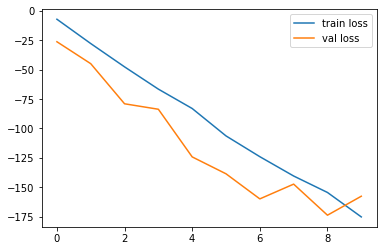

In [34]:
plt.figure()
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show();

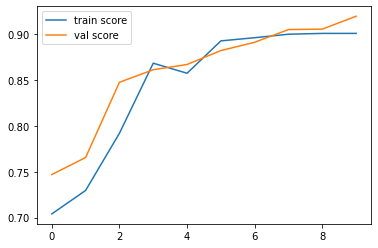

In [35]:
plt.figure()
plt.plot(train_scores, label='train score')
plt.plot(val_scores, label='val score')
plt.legend()
plt.show();

# Results visualization

In [36]:
best_model = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model.pth'), map_location=torch.device(DEVICE))

## The predicted masks are in the form of probabilities, once we clip the values to 1 which are above a certain threshold (usually 0.5) we can further post-process it to give clearer lanes. But still the model seems to understand the task at hand.  

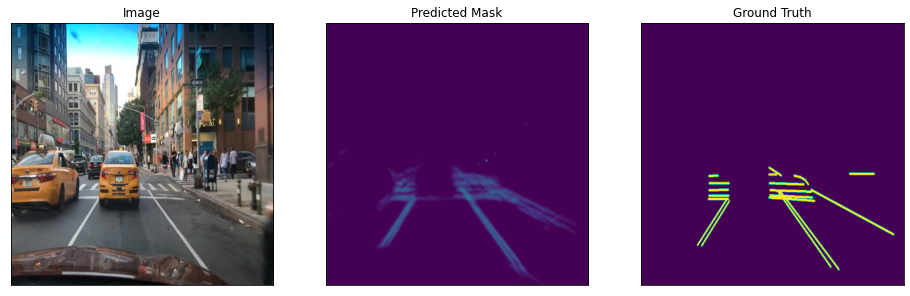

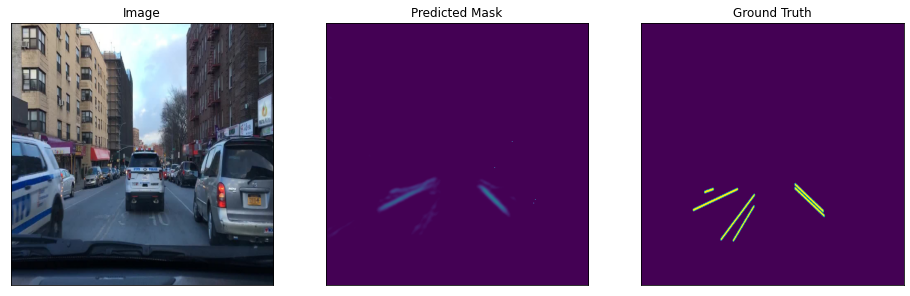

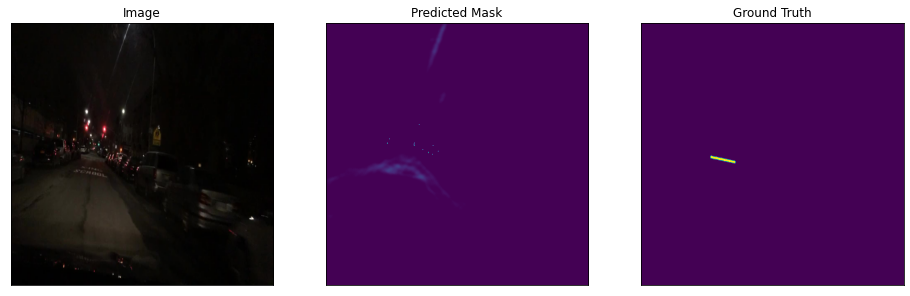

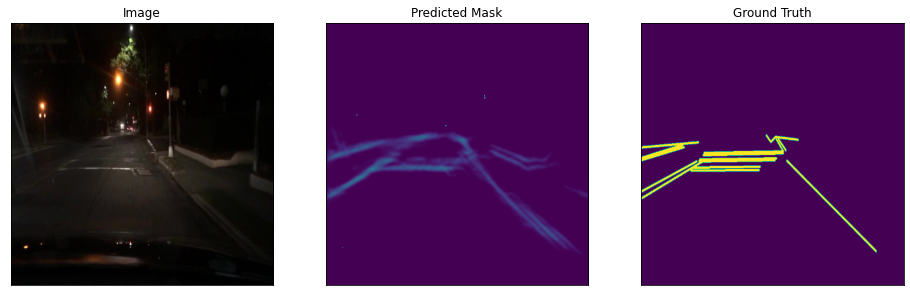

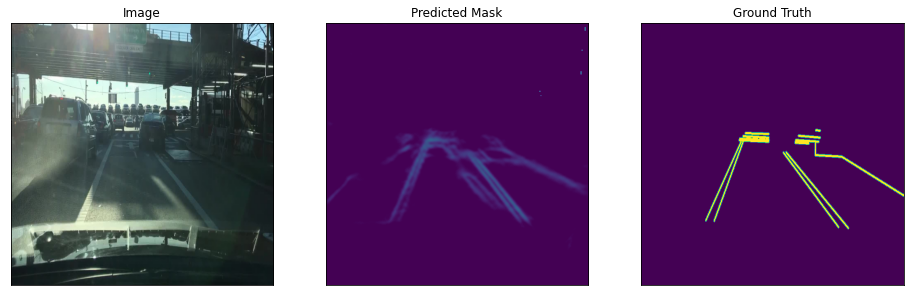

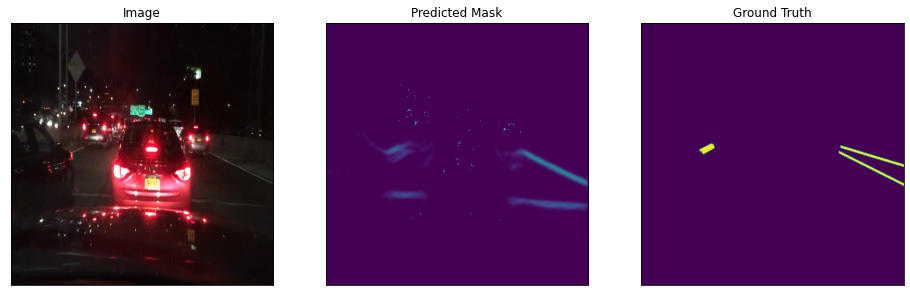

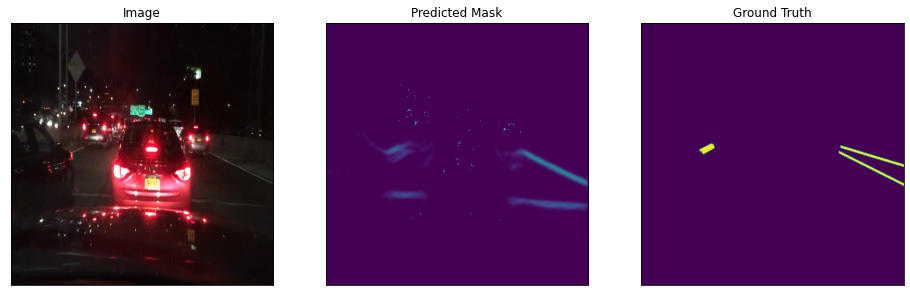

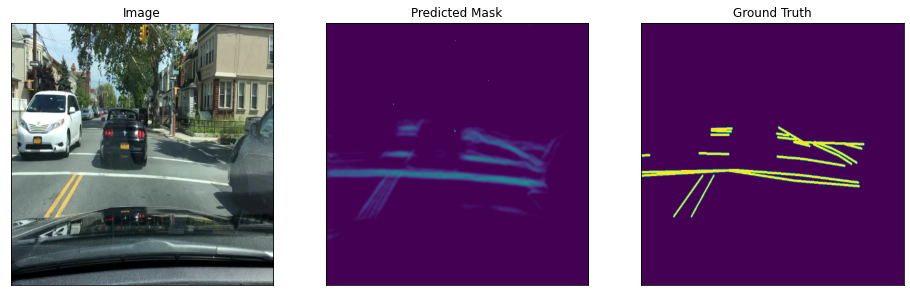

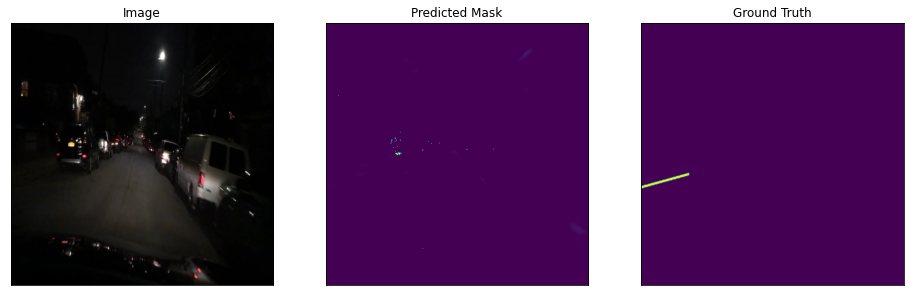

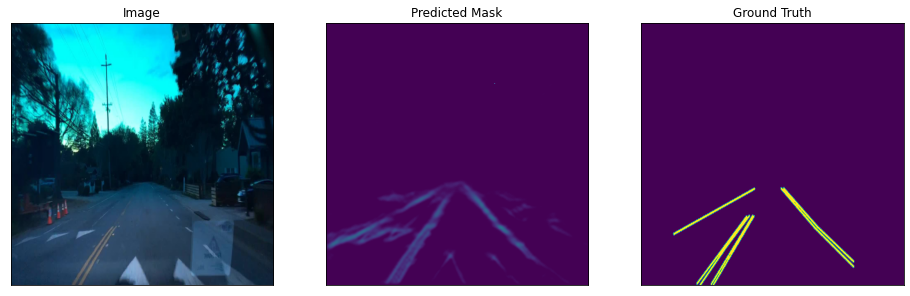

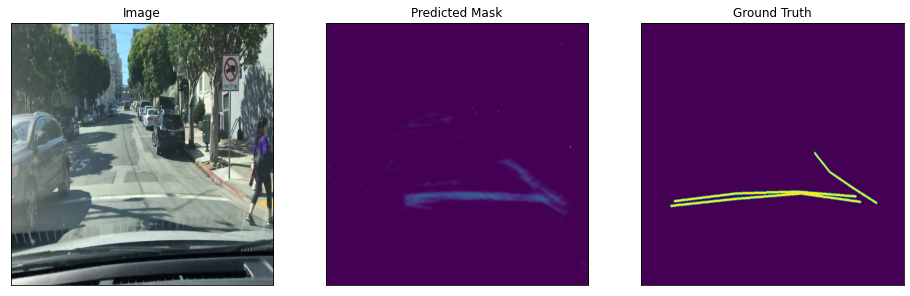

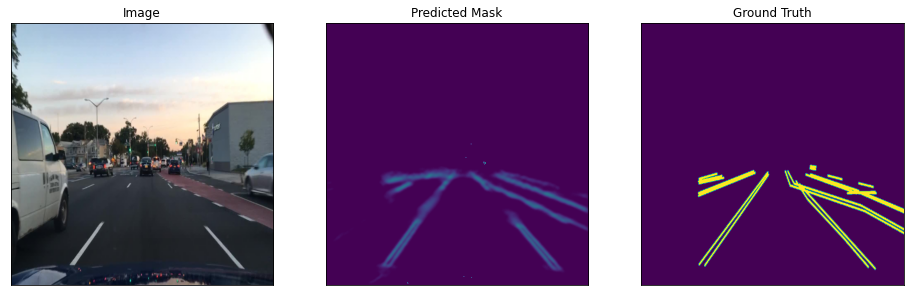

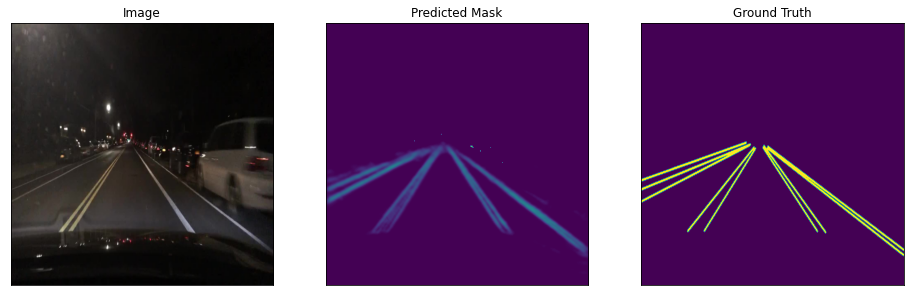

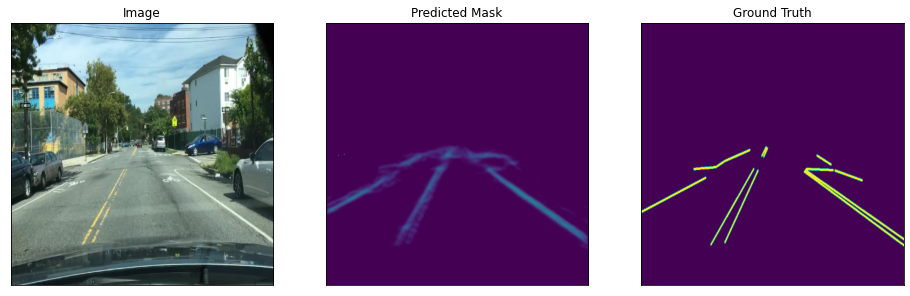

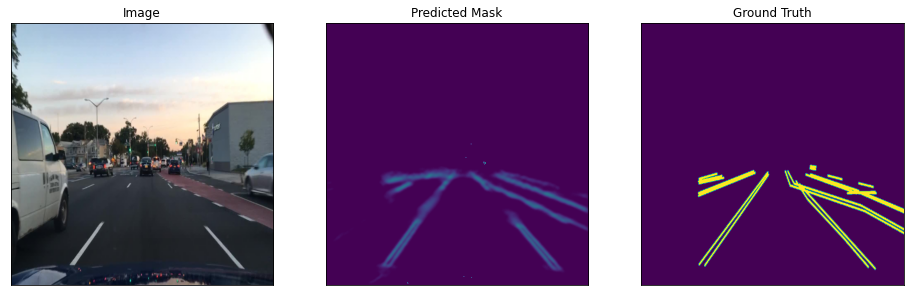

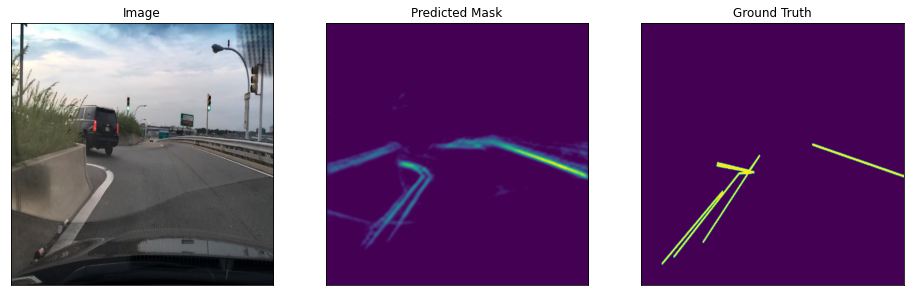

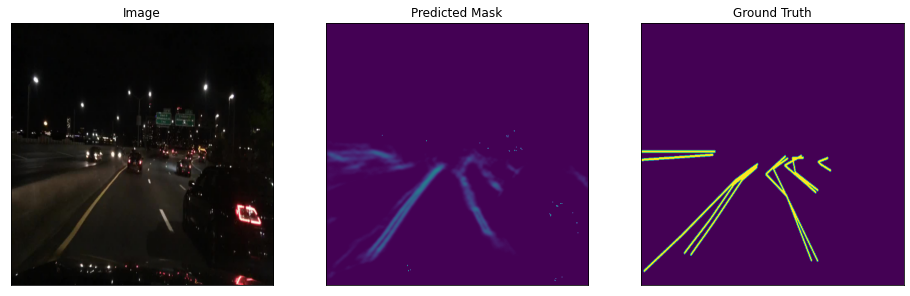

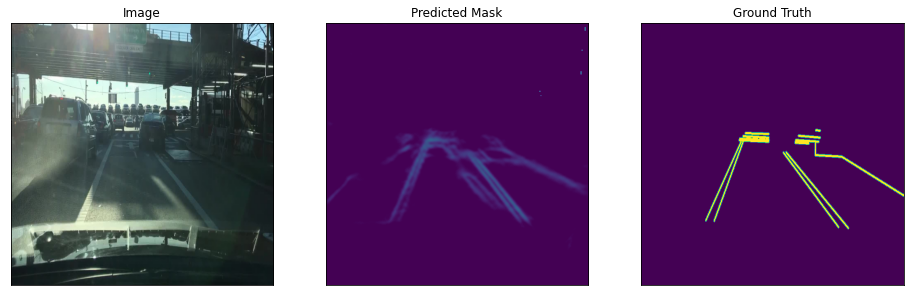

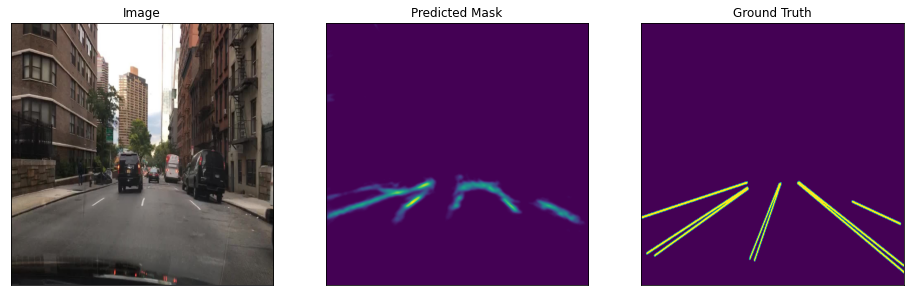

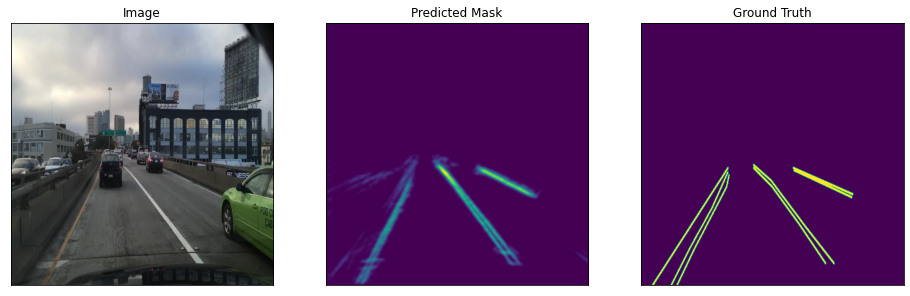

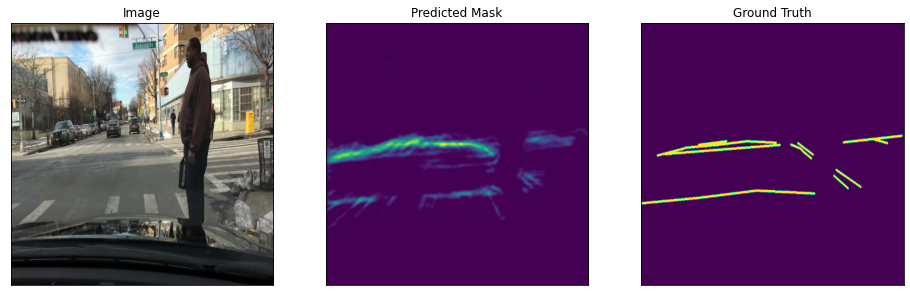

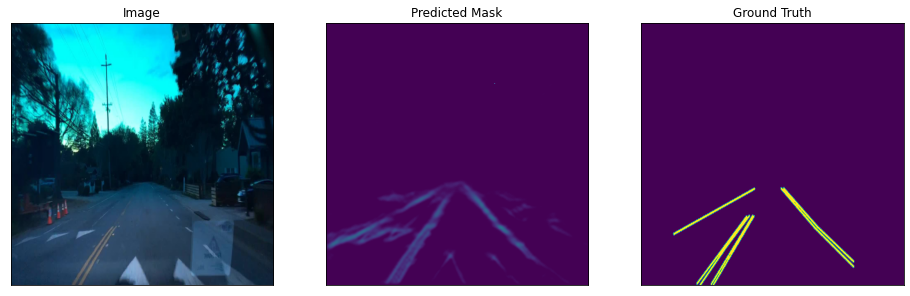

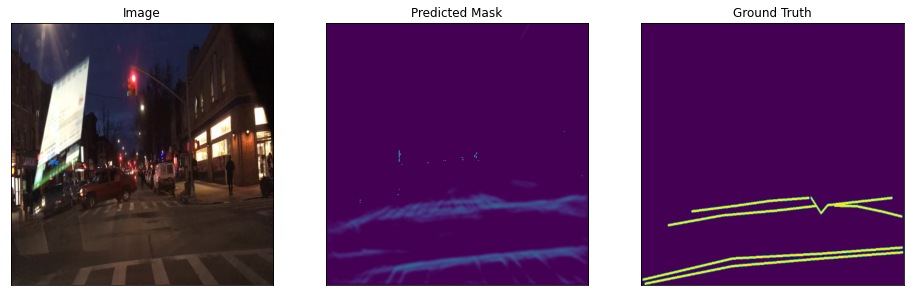

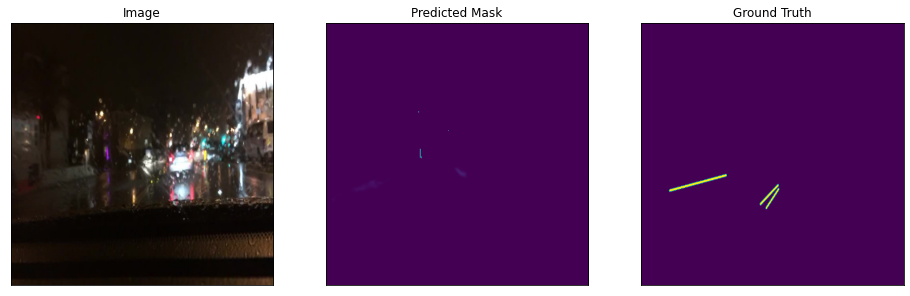

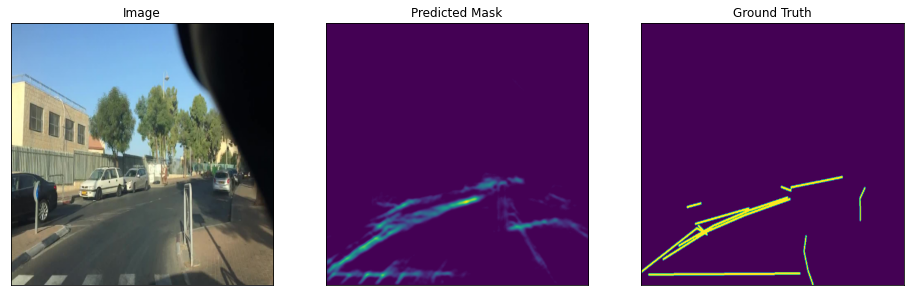

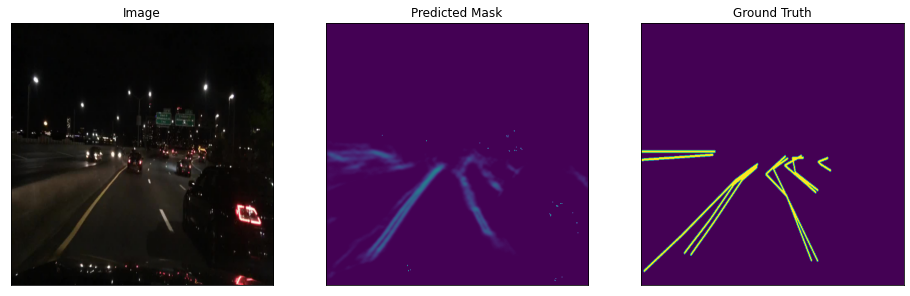

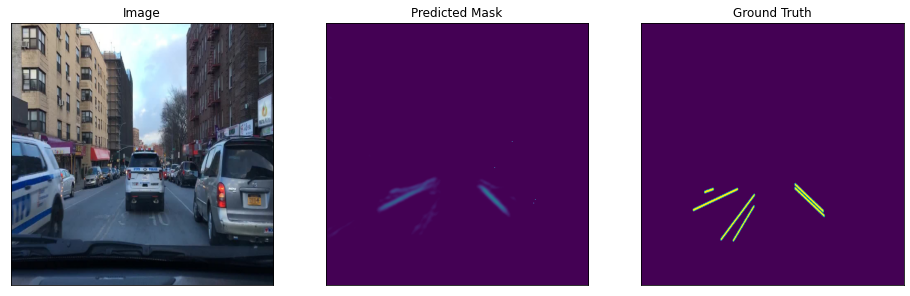

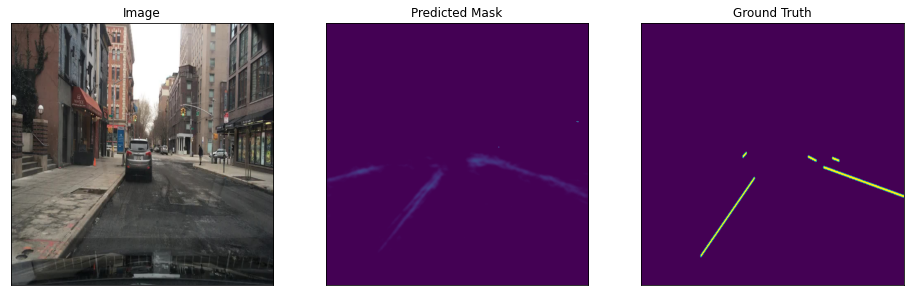

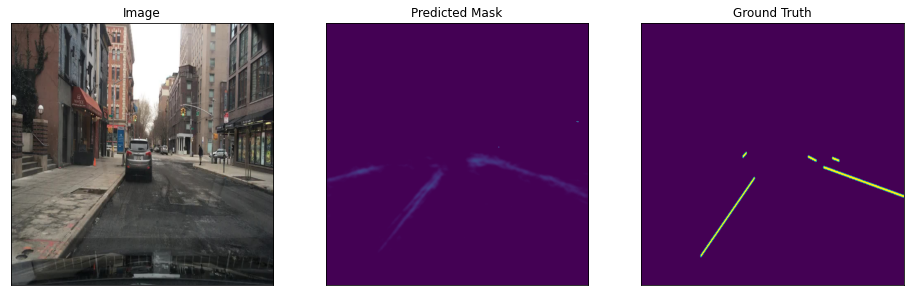

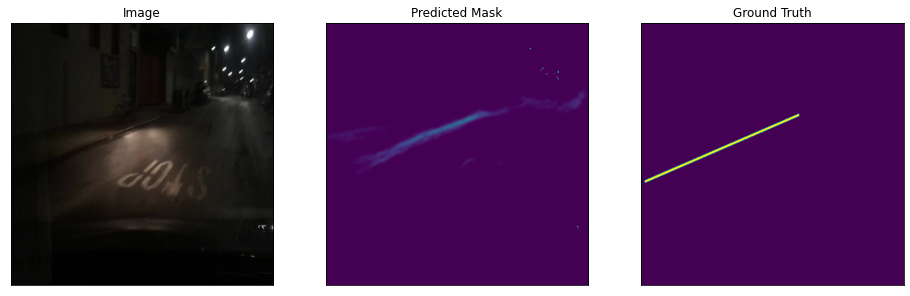

In [37]:
test_dataset = SegDataset(val_paths, 
                             'val',
                             preprocessing=get_preprocessing()
                        )

test_dataloader = D.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

test_dataset_vis = SegDataset(val_paths, 'val')

best_model.eval()

for i in range(30):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image = test_dataset[n][0]
    mask_vis = test_dataset_vis[n][1].astype('uint8')
    mask_vis = np.squeeze(mask_vis, axis=-1) 
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    with torch.set_grad_enabled(False):
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round().astype('uint8'))
        
    visualize(
        image=image_vis, 
        predicted_mask=pr_mask,
        ground_truth=mask_vis)

## The above inference over validation samples shows that the model has achieved some pretty good understanding of the task at hand. 
## Even when the lighting in the images are low the model is able to idnetify the lanes. Convolutions extract these kind of patterns through kernel extratction and deep parameter sharing, which in turn makes them more efficient.
## The predicted areas gives us some approximate localization upon which we can apply filtering techniques to refine the required edges, using gaussian removal we can filter some normal-noise.